In [1]:
#This program finds homography points after locating the 4 QR codes (and each of their 4 corners) in the corners of the screen. 

#Questions:
#Order of QR corner readout
#Look at barcode.polygon elements

#Good videos to watch on this subject.
#https://www.youtube.com/watch?v=SrZuwM705yE
#https://www.youtube.com/watch?v=-4MPtERPq2E

In [2]:
# import the necessary packages
import cv2
import numpy as np
from pyzbar.pyzbar import decode
from matplotlib import pyplot as plt
import random

#from skimage.transform import ProjectiveTransform
#from skimage.io import imread

In [3]:
#Function that changes the color channels from OpenCV to Matplotlib for display purposes
# b/c .imshow doesn't work in Jupyter Notebooks.

def show_with_matplotlib(img, title):
    #Shows an image using matplotlib capabilities

    # Convert BGR image to RGB
    img_RGB = img[:, :, ::-1]

    # Show the image using matplotlib:
    plt.imshow(img_RGB)
    plt.title(title)
    plt.show()

In [4]:
#Read in images, change to correct dir later and create a loop to read in all images in a data set.

img = cv2.imread("Test_Images/20210127_133346.jpg")

In [5]:
#Sets counter for QR corners, to check to see if it found 16.

MIN_MATCH_COUNT = 0

xm = 0
ym = 0

In [6]:
#Screen information, in mm ("True Coordinates"), upper-left corner is origin. Order: UL, LL, UR, LR "Destination"
#upper edge of screen is horizontal, lower-left corner is negative because it's not perfectly rectangular

ScreenCornersmm = np.array([[0.0,0.0],[0.0,1218],[1543,1218],[1543,0]],np.float32)

# ~2.8982 pixels/mm
# bottom: 28.264 in = 717.9056 mm
# 1543, 1218


ScreenCornerspx = np.array([[0,0],[50,800],[1200,200],[1500,1200]],np.int32)

#Finds homography matrix (H) and the mask (inliers and outliers).
H, mask = cv2.findHomography(ScreenCornerspx, ScreenCornersmm, cv2.RANSAC,5.0)
print(H)

[[-1.51592982e+00  9.47456140e-02 -3.67937405e-13]
 [-1.49578947e+00  1.86973684e+00 -2.90570616e-13]
 [-1.85964912e-03  3.24561404e-04  1.00000000e+00]]


In [7]:
#QR Code Coordinates in mm in relation to screen UL, LL, UR, LR

QRCornersmm = np.array([[10.7,7.7],[6.9,536.6],[675.2,9.5],[675.9,541.3],
                     [12.7,68.6],[7.1,603.3],[673.6,68.8],[674.6,600.7],
                     [71.5,5.3],[66.1,543.7],[734.6,11.2],[735.2,542.6],
                     [73.6,66.7],[66.5,603.2],[732.7,70.7],[733.9,602.0]],np.float32)

In [8]:
#bogus entries

QRCornerspx = np.array([[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]],np.int32)
    
#QRCornerspx will be decoded QR corners, below.

In [9]:
#Gets x,y coordinates of QR code. Use print(code) later to print garbled paragraph of info.
code = decode(img)

#Tells us the position and the size of the QR code.
#   print(barcode.rect) gives left value,top value, width, and height of bounding box
#print(barcode.polygon) = gives coordinates of QR corners

In [10]:
for barcode in decode(img):
    #Decodes barcode and converts it into a string)
    myData = barcode.data.decode('utf-8')

  
    #Puts polygon coordinates of QR code in np.array named pts.
    pts = np.array([barcode.polygon],np.int32)
    print("pts.shape:", pts.shape)
    print("QRCornerspx.shape", QRCornerspx.shape)

    #Computer average x and y of QR Code coordinates. 
    xm = (pts[0][0][0] + pts[0][1][0] + pts[0][2][0] + pts[0][3][0]) / 4
    ym = (pts[0][0][1] + pts[0][1][1] + pts[0][2][1] + pts[0][3][1]) / 4

    #Determine which QR coordinates are UL, LL, UR, and LR
    offset = -1
    
    if myData.find('upper-left') > -1: #lowercase because that's how the barcode was formed.
        offset = 0
        print("UL barcode found.")
        
    if myData.find('Lower-left') > -1:
        offset = 4
        print("LL barcode found.")
        
    if myData.find('Upper-right') > -1:
        offset = 8
        print("UR barcode found.")
        
    if myData.find('Lower-right') > -1:
        offset = 12
        print("LR barcode found.")
        
    if offset < 0:
        print("Foreign QR Code found.")
        continue
        
    for i in range(4):
           
        #x and y coordinates of the first point of the barcode read in.
        #We don't know which barcode corner it is yet.
        x = pts[0][i][0]
        y = pts[0][i][1] 
        
        
        if x < xm and y < ym:
            QRCornerspx[0 + offset] = pts[0][i] #UL corner of QR Code
            MIN_MATCH_COUNT = MIN_MATCH_COUNT + 1
            print("UL corner of QR Code found")
            if offset == 0:
                print(pts[0][i])
                ScreenCornerspx[0] = pts[0][i]
            continue
            
        if x < xm and y > ym:
            QRCornerspx[1 + offset] = pts[0][i] #LL corner of QR Code
            MIN_MATCH_COUNT = MIN_MATCH_COUNT + 1
            print("LL corner of QR Code found")
            if offset == 12:
                print(pts[0][i])
                ScreenCornerspx[1] = pts[0][i]
            continue
            
        if x > xm and y < ym:
            QRCornerspx[2 + offset] = pts[0][i] #UR corner of QR Code
            MIN_MATCH_COUNT = MIN_MATCH_COUNT + 1
            print("UR corner of QR Code found")
            if offset == 8:
                print(pts[0][i])
                ScreenCornerspx[3] = pts[0][i]
            continue
            
        if x > xm and y > ym:
            QRCornerspx[3 + offset] = pts[0][i] #LR corner of QR Code
            MIN_MATCH_COUNT = MIN_MATCH_COUNT + 1
            print("LR corner of QR Code found")
            if offset == 4:
                print(pts[0][i])
                ScreenCornerspx[2] = pts[0][i]
            continue
            
        print("Error. Point not found.") 


    #prints message of QR code and coordinate array of each.
    print("Message in Barcode:", myData)   
    print(QRCornerspx)
    print(ScreenCornerspx)
    print("\n")
    
    #Draws lines around polygon. True means it's a closed polygon, color, thickness.
    #"myData" in cv2.putText means that the QR message of that QR code is printed directly on the image.
    cv2.polylines(img,[pts],True,(255,0,0),3)
    pts2 = np.array([barcode.polygon],np.int32)
    cv2.putText(img, myData,(pts2[0][0][0],pts2[0][0][1]),cv2.FONT_HERSHEY_SIMPLEX, 1.3,(0,255,255),2)
    #cv2.putText(img, myData,(pts2[0][0][0],pts2[0][0][1]),cv2.FONT_HERSHEY_SIMPLEX, 0.9,(0,0,255),3)

#MIN_MATCH_COUNT check, to see if program found 16 corners
print(MIN_MATCH_COUNT)
print(ScreenCornerspx)

pts.shape: (1, 4, 2)
QRCornerspx.shape (16, 2)
LL barcode found.
UL corner of QR Code found
LL corner of QR Code found
LR corner of QR Code found
[1614 1232]
UR corner of QR Code found
Message in Barcode: Lower-left corner of screen
[[   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [1529 1151]
 [1535 1246]
 [1609 1139]
 [1614 1232]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]]
[[   0    0]
 [  50  800]
 [1614 1232]
 [1500 1200]]


pts.shape: (1, 4, 2)
QRCornerspx.shape (16, 2)
UR barcode found.
UL corner of QR Code found
LL corner of QR Code found
LR corner of QR Code found
UR corner of QR Code found
[1561  273]
Message in Barcode: Upper-right corner of screen
[[   0    0]
 [   0    0]
 [   0    0]
 [   0    0]
 [1529 1151]
 [1535 1246]
 [1609 1139]
 [1614 1232]
 [1480  271]
 [1482  370]
 [1561  273]
 [1563  371]
 [   0    0]
 [   0    0]
 [   0    0]
 [   0    0]]
[[   0    0]
 [  50  800]
 [1614 1232]
 [1561  273]]


pts.s

In [11]:
#Homography Transform
H, mask = cv2.findHomography(ScreenCornerspx, ScreenCornersmm, cv2.RANSAC,5.0)
print(H)

print("Number of elements in pts:", len(pts))
print("Number of elements in QRCornerspx:", len(QRCornerspx))
#print("Code", code)

[[ 9.61138254e-01 -8.25219713e-02 -3.07802099e+02]
 [-6.17527355e-03  9.40185399e-01 -2.47031012e+02]
 [-1.53003810e-04 -1.06003597e-05  1.00000000e+00]]
Number of elements in pts: 1
Number of elements in QRCornerspx: 16


In [12]:
#def get_destination_points(QRCornerspx): #passes in array of 16 found corners in order UL, LL, UR, LR 
"""
-Get destination points from corners of warped images
-Approximating height and width of the rectangle: we take maximum of the 2 widths and 2 heights
Args:
    QRCornerspx: list
Returns:
    destination_corners: list
    height: int (***I don't like h and w as integers: less precise. Change???***)
    width: int
"""
#calculate top width of screen (tombstoned still), distance between UL:ul and UR:ur using sqrt of (Ax-Bx)^2+(Ay-By)^2
w1 = np.sqrt((QRCornerspx[0][0] - QRCornerspx[10][0]) ** 2 + (QRCornerspx[0][1] - QRCornerspx[10][1]) ** 2)
    
#bottom width of screen (tombstoned still), distance between LL:ll and LR:lr
w2 = np.sqrt((QRCornerspx[5][0] - QRCornerspx[15][0]) ** 2 + (QRCornerspx[5][1] - QRCornerspx[15][1]) ** 2)
    
#find maximum width
w = max(int(w1), int(w2))

#calculate left height of screen (tombstoned still), distance between UL:ul and LL:ll
h1 = np.sqrt((QRCornerspx[0][0] - QRCornerspx[5][0]) ** 2 + (QRCornerspx[0][1] - QRCornerspx[5][1]) ** 2)
    
#calculate right height of screen (tombstoned still), distance between UR:ur and LR:lr
h2 = np.sqrt((QRCornerspx[10][0] - QRCornerspx[15][0]) ** 2 + (QRCornerspx[10][1] - QRCornerspx[15][1]) ** 2)
    
#find maximum height
h = max(int(h1), int(h2))

destination_corners = np.float32([(0, 0), (w - 1, 0), (0, h - 1), (w - 1, h - 1)])
    
print('\nThe destination points are: \n')
for index, c in enumerate(destination_corners):
        character = chr(65 + index) + "'"
        print(character, ':', c)
        
print('\nThe approximated height and width of the original image is: \n', (h, w))
    #return destination_corners, h, w


The destination points are: 

A' : [0. 0.]
B' : [1217.    0.]
C' : [   0. 1542.]
D' : [1217. 1542.]

The approximated height and width of the original image is: 
 (1543, 1218)


In [13]:
#get_destination_points(QRCornerspx)


In [14]:
#unwarpattempt = cv2.warpPerspective(img, H, (w, h), flags=cv2.INTER_CUBIC)
#show_with_matplotlib(unwarpattempt, 'Unwarped Image')


The homography matrix is: 
 [[ 9.61138254e-01 -8.25219713e-02 -3.07802099e+02]
 [-6.17527355e-03  9.40185399e-01 -2.47031012e+02]
 [-1.53003810e-04 -1.06003597e-05  1.00000000e+00]]


Text(0.5, 1.0, 'Unwarped Image')

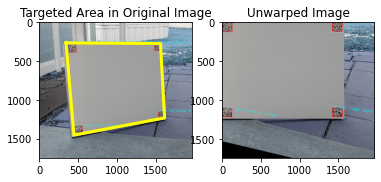

In [15]:
#def unwarp(img, ScreenCornerspx, ScreenCornersmm):
"""
Args:
    img: np.array
    src: list
    dst: list
Returns:
    un_warped: np.array
"""
h, w = img.shape[:2]
H, _ = cv2.findHomography(ScreenCornerspx, ScreenCornersmm, method=cv2.RANSAC, ransacReprojThreshold=3.0)
print('\nThe homography matrix is: \n', H)
un_warped = cv2.warpPerspective(img, H, (w, h), flags=cv2.INTER_CUBIC)

# plot

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img)
x = [ScreenCornerspx[0][0], ScreenCornerspx[1][0], ScreenCornerspx[2][0], ScreenCornerspx[3][0], ScreenCornerspx[0][0]]
y = [ScreenCornerspx[0][1], ScreenCornerspx[1][1], ScreenCornerspx[2][1], ScreenCornerspx[3][1], ScreenCornerspx[0][1]]
ax1.plot(x, y, color='yellow', linewidth=3)
ax1.set_ylim([h, 0])
ax1.set_xlim([0, w])
ax1.set_title('Targeted Area in Original Image')
ax2.imshow(un_warped)
ax2.set_title('Unwarped Image')
#plt.show()
    #return un_warped

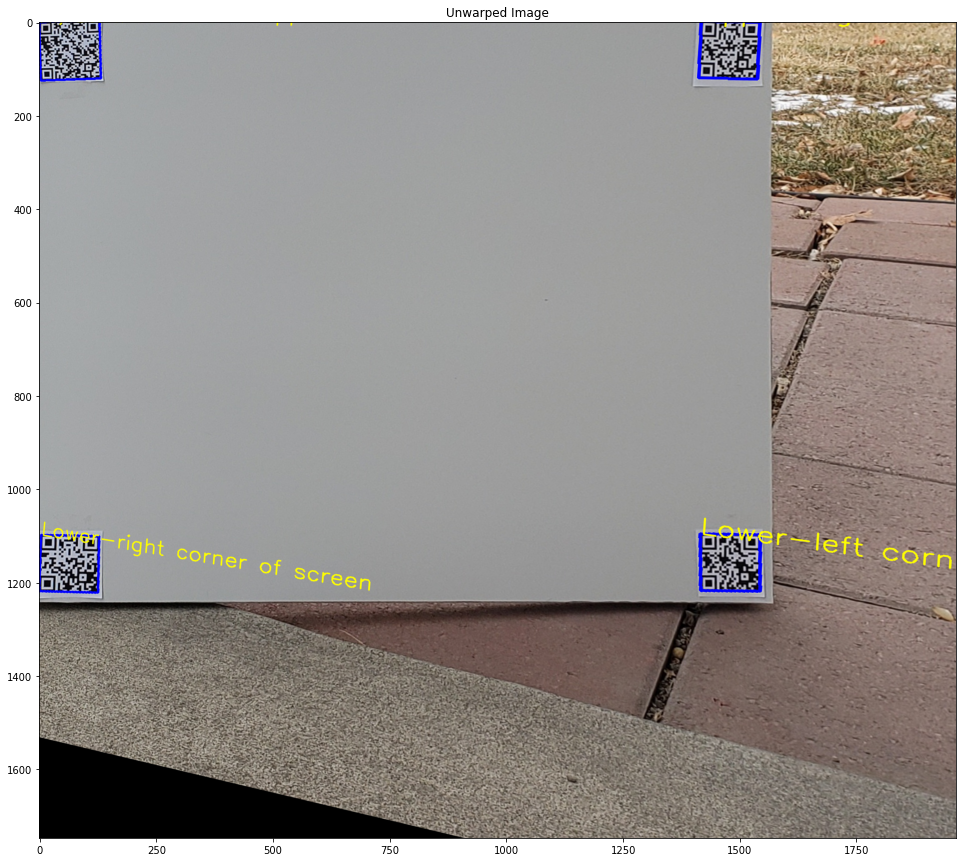

In [16]:
#Creates plot of original image, resized for visibility here.
plt.rcParams["figure.figsize"] = (20,15)

# Show loaded image:
show_with_matplotlib(un_warped, 'Unwarped Image')

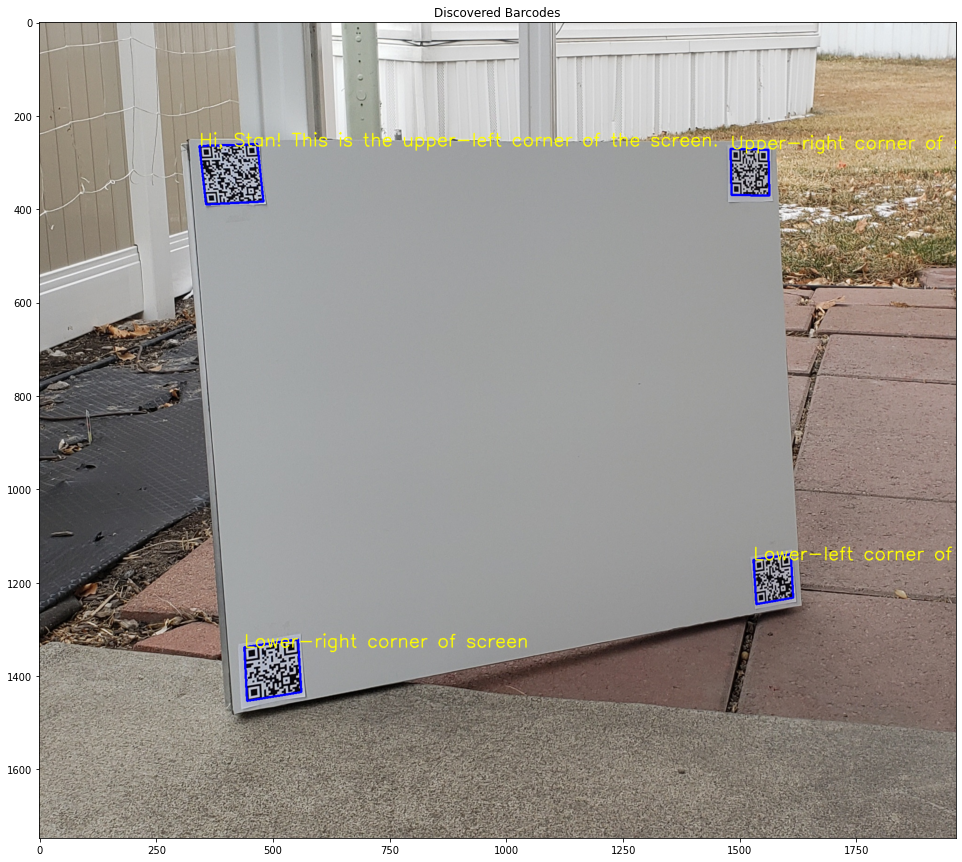

In [17]:
#Creates plot of original image, resized for visibility here.
plt.rcParams["figure.figsize"] = (20,15)

# Show loaded image:
show_with_matplotlib(img, 'Discovered Barcodes')

#plt.imshow(img),plt.show()
#cv2.imshow("Image", img)
#cv2.waitKey(0) #Don't use .waitKey with Jupyter notebooks
#cv2.destroyAllWindows()